<a href="https://colab.research.google.com/github/sashavlasits/Data-Science/blob/main/Unit7/SMV_Unit7ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting Curves: Concepts

What you'll do:

- Answer questions about what a GP is, and its relationship to GLMs and splines.
- Practice applying each of: polynomial modeling, b splines, and GPs
- You'll get a chance to read about and try to comprehend a more standard implementation of a GP.

Have fun!

In [ ]:
!pip install preliz
!pip install bambi

In [4]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import preliz as pz
import pymc as pm
import bambi as bmb

**Task1**:

Why would you ever want to include a polynomial element in a model you built? What's the benefit of using polynomials to model?

You want to use a polynomial element when your data is all curvy! The benefit of this is that you can make your model fit the contours of your data better, allowing you to capture more nuance and (hopefully) accuracy.

**Task2**:

Why would you ever NOT want to include a polynomial element in a model you built?

You don't want to use a polynomial element if the data is largely straight with not as many humps and such. I mean, technically you could use a one degree polynomial, but there's not much point in that since it just makes it more needlessly complicated.

**Task3**:

What's the point of using b splines?

We use b-splines because they stop us from doing too much overfitting. We can be tempted to just use higher and higher degree polynomials to try to fit every tiny nook and cranny of our data, but this can be quite bad. B splines help us do this but in a more accurate way due to the piecewise nature.

**Task4**:

Describe what a Gaussian Process is, in your own words. *Don't worry about being correct, just try to explain it to yourself*. I will not grade this question for accuracy.

So basically you have a whole load of data points that you're trying to play an elaborate game of connect the dots with. We take all of these data points and we're trying to draw the best line between them, the line that will capture the most theoretical data points. The gaussian process basically tries to make all of the possible lines between the points (or knots) to find the best combination that will be the best predictor. It will make this prediciton based on the dots themselves as well as their relationships to each other.

**Task5**:

Fit three models to the howell data (from Unit5ExercisesSF): polynomial, b splines, and Gaussian Process.

Plot the posterior predictive check on a scatter plot, as is standard/required.

Hint: Distributional models (variable variance) work better on the howell data.


In [5]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [6]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


In [ ]:
model_poly_4 = bmb.Model("weight ~ poly(height, degree=4)", howell)
idata_poly_4 = model_poly_4.fit()

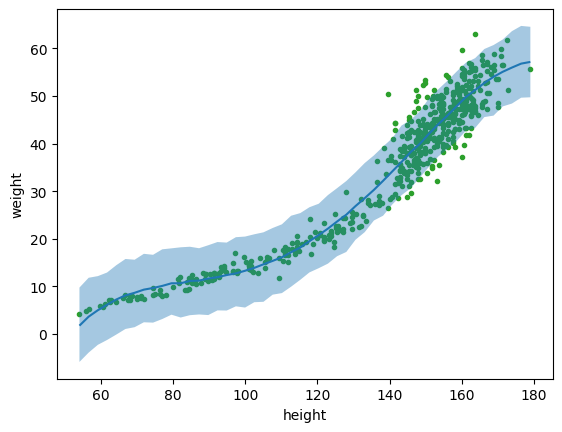

In [20]:
#plot of posterior predictive dist
bmb.interpret.plot_predictions(model_poly_4, idata_poly_4, "height", pps=True)
#raw data
plt.plot(howell.height, howell.weight, "C2.", zorder=-3)

She looks gorgenous!

In [ ]:
num_knots = 6
knots = np.linspace(53, 180, num_knots+2)[1:-1]
model_spline = bmb.Model("weight ~ bs(height, degree=3, knots=knots)", howell)
idata_spline = model_spline.fit()

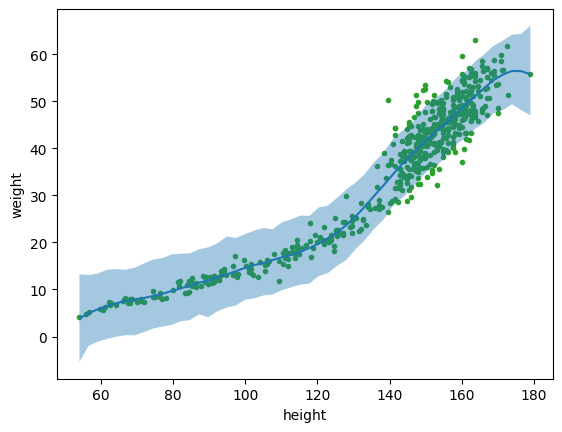

In [22]:
bmb.interpret.plot_predictions(model_spline, idata_spline, "height", pps= True)
plt.plot(howell.height, howell.weight, "C2.", zorder=-3)

She is also lovely!

In [26]:
#ig stands for inverse gamma
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [ ]:
m, c = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[53, 180], lengthscale_range=[1, 30], cov_func="ExpQuad"
)

print("Recommended smallest number of basis vectors (m):", m)
print("Recommended smallest scaling factor (c):", np.round(c, 1))

In [ ]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(howell.height.values))
}

priors = {
    "hsgp(height, m=168, c=8.0)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_hsb = bmb.Model("weight ~ 0 + hsgp(height, m=168, c=8.0)", howell, priors=priors)
idata_hsb = model_hsb.fit()

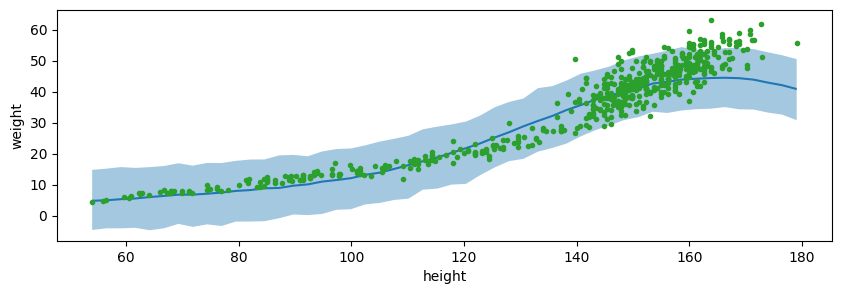

In [35]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["height"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(howell["height"].values, howell["weight"].values, "C2.")

I like this one too!

**Task6**:

Read the article on the pymc website about GP implementation on the Mauna Loa CO$_{2}$ data combined with CO$_{2}$ ice core data from the south pole.
[Link here.](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa2.html)

Write down one thing you learned about GPs from reading the article.

Note: You probably won't understand much in this article--I had to read it about five times before I figured out what was going on. The points of this task are to: hammer home that good GP implementations are extremely technical, and increasure your exposure to the kinds of problems traditional GPs are good at solving.

I learned about the use of uncertainty in making your model more open to other possibilities. There was clear uncertainty in the ice core data because it's not a direct reflection of CO2 levels. It was also more uncertain than the Mauna Loa data because it didn't have the seasonal consideration due to vegetation dieoff. So by making the x value uncertain, in this and other cases we can account for some problems with our data.

**Task7**:

Describe your favorite graph from the article in the previous task with as much technical detail as you can muster.

Explain why its your favorite.

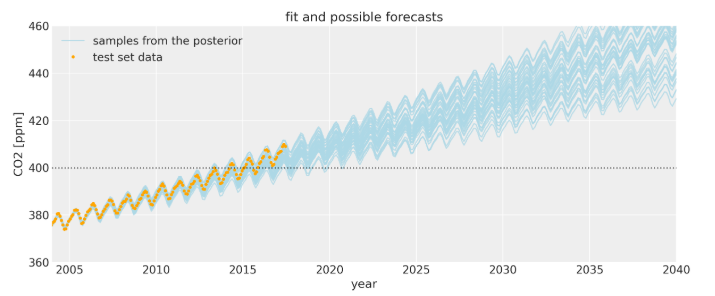

This is my favorite graph. To be honest, it's mostly just my favorite grpah because I like the colors and the shape of the graph reminds me of ocean waves or curving spaghetting, both of which are things that I like.

This graph shows the overlap of the Mauna Loa CO2 data with the projections of the model based on the ice core data from the south pole. These projections are from the model that was adjusted for seasonal variation in the CO2 measures that could not be captured by the ice cores. The overlap with the mauna loa data looks very good, and then the projections go past the recorded data into the future, where the variance in the projection starts to get more pronounced, showing varying levels of increase in the amount of atmospheric CO2 based on historic levels.